In [1]:
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import tqdm
# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###### https://www.unb.ca/cic/datasets/triple-r-dataset-2024.html --- DataSource

In [2]:
import pandas as pd

# Replace with your file paths
train  = pd.read_json('train.json')
test = pd.read_json('test.json')

In [3]:
# Check the distribution of the 'Label' column
label_distribution = train['label'].value_counts()
label_distribution

label
half-true      2078
false          1957
mostly-true    1893
barely-true    1642
true           1638
pants-fire      839
Name: count, dtype: int64

C:\Users\quesi\AppData\Local\Temp\ipykernel_3092\3975494141.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


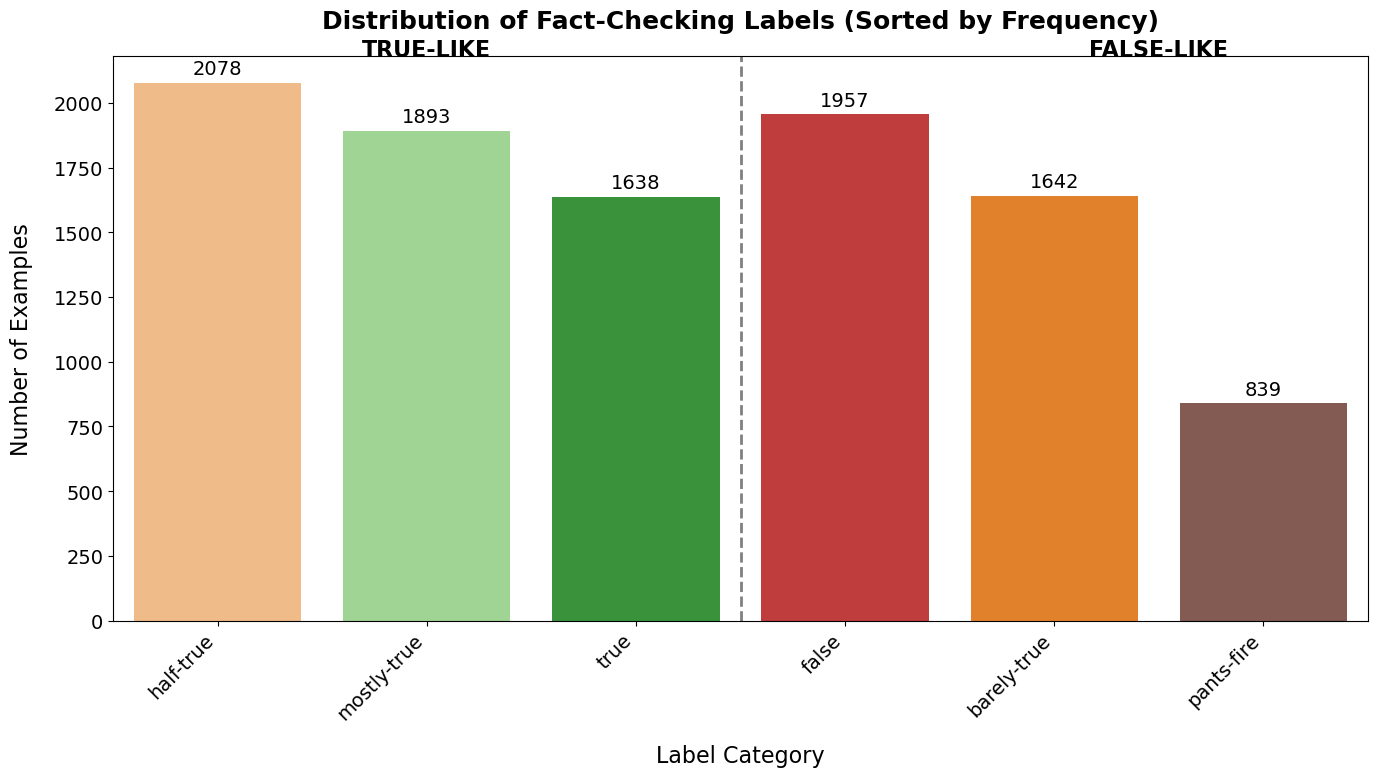

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set global font sizes
plt.rcParams.update({
    'axes.titlesize': 18,      # Title font size
    'axes.labelsize': 16,      # X and Y axis label size
    'xtick.labelsize': 14,     # X-axis tick label size
    'ytick.labelsize': 14,     # Y-axis tick label size
    'legend.fontsize': 14,     # Legend font size
    'font.size': 14            # General font size
})

# Define colors
label_colors = {
    'true': '#2ca02c',         # normal green
    'mostly-true': '#98df8a',  # light green
    'half-true': '#ffbb78',    # orange
    'barely-true': '#ff7f0e',  # normal orange-red
    'false': '#d62728',        # dark red
    'pants-fire': '#8c564b'    # light red/brown
}

# Get label counts
label_counts = train['label'].value_counts()

# Split and sort categories
true_labels = ['true', 'mostly-true', 'half-true']
false_labels = ['barely-true', 'false', 'pants-fire']
true_sorted = label_counts[true_labels].sort_values(ascending=False)
false_sorted = label_counts[false_labels].sort_values(ascending=False)
sorted_labels = pd.concat([true_sorted, false_sorted])

# Create figure with adjusted size
plt.figure(figsize=(14, 8))

# Create bar plot
ax = sns.barplot(
    x=sorted_labels.index,
    y=sorted_labels.values,
    palette=[label_colors[label] for label in sorted_labels.index]
)

# Add divider and category labels
plt.axvline(2.5, color='gray', linestyle='--', linewidth=2)
plt.text(1, max(sorted_labels.values)*1.05, "TRUE-LIKE", 
         ha='center', fontsize=16, fontweight='bold')
plt.text(4.5, max(sorted_labels.values)*1.05, "FALSE-LIKE", 
         ha='center', fontsize=16, fontweight='bold')

# Enhance plot elements
plt.title("Distribution of Fact-Checking Labels (Sorted by Frequency)", 
          pad=20, fontweight='bold')
plt.xlabel("Label Category", labelpad=15)
plt.ylabel("Number of Examples", labelpad=15)

# Rotate x-labels and adjust layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=14)

# Save and show
plt.savefig("label_distribution_sorted_large_font.png", 
            dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [6]:
test.head(10)

,id,label,statement,evidence
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,"[""Building a wall"" on the border ""will take li..."
1,11685.json,false,Wisconsin is on pace to double the number of l...,"[""This is the governor's worst year of his adm..."
2,11096.json,false,Says John McCain has done nothing to help the ...,"[""I'm very disappointed in John McCain, becaus..."
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"[Mary Anne Ostrom, Cornilles’ campaign manager..."
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,[3. Wisconsin Democratic Party: When asked by ...
5,5962.json,true,Over the past five years the federal governmen...,"[""Over the past five years the federal governm..."
6,7070.json,true,Says that Tennessee law requires that schools ...,"[Says that ""Tennessee law requires that school..."
7,1046.json,barely-true,"Says Vice President Joe Biden ""admits that the...","[""Democrats said the stimulus would immediatel..."
8,12849.json,true,Donald Trump is against marriage equality. He ...,[Speaking at the Democratic National Conventio...
9,13270.json,barely-true,We know that more than half of Hillary Clinton...,"[""We know that more than half of Hillary Clint..."


In [11]:
# Check for empty lists in the 'evidence' column
empty_evidence = test[test['evidence'].apply(lambda x: isinstance(x, list) and len(x) == 0)]

# Display rows with empty lists in 'evidence'
print(empty_evidence)

              id        label  \
88     8761.json        false   
150   12210.json        false   
190   12427.json  mostly-true   
236    4095.json  mostly-true   
357    9141.json  barely-true   
393    1394.json        false   
457    2181.json    half-true   
486     474.json  barely-true   
707    4318.json    half-true   
793    1280.json  barely-true   
796    7814.json  mostly-true   
924    5510.json  mostly-true   
948   10893.json  mostly-true   
1012   4526.json        false   
1087   5788.json         true   
1119   3697.json  mostly-true   
1181   8979.json  barely-true   
1201  13172.json    half-true   
1250   6045.json   pants-fire   

                                              statement evidence  
88    A judges order means theres a Constitution exe...       []  
150   Charlottes anti-discrimination ordinance would...       []  
190   Old City in Philadelphiaused to have more than...       []  
236   As weve seen that federal support for states d...       []  
357 

In [17]:
# View the first evidence item
print(train.loc[500, 'evidence'])

His statement parallels a claim in Hillary Clinton’s May campaign ad: "In 2006, Donald Trump was hoping for a real estate crash." We touched on this before when Hillary Clinton claimed in a television commercial that "In 2006, Donald Trump was hoping for a real estate crash." We ruled that claim Mostly True. But this claim is different. PolitiFact, "Hillary Clinton faults Donald Trump for hoping for real estate crash that led to the Great Recession," May 24, 2016. PolitiFact, "Hillary Clinton faults Donald Trump for hoping for real estate crash that led to the Great recession," May 26, 2016


In [15]:
import html

train['evidence'] = train['evidence'].apply(
    lambda x: html.unescape(" ".join(x)) if isinstance(x, list) else html.unescape(x)
).str.replace(r"\\'", "'", regex=True).str.replace(r'\\"', '"', regex=True)


import html

test['evidence'] = test['evidence'].apply(
    lambda x: html.unescape(" ".join(x)) if isinstance(x, list) else html.unescape(x)
).str.replace(r"\\'", "'", regex=True).str.replace(r'\\"', '"', regex=True)

## Exploratory Analysis

In [19]:
train['statement length'] = train['statement'].str.len()
train['evidence length'] = train['evidence'].str.len()

test['statement length'] = test['statement'].str.len()
test['evidence length'] = test['evidence'].str.len()

In [23]:
train.head(5)

,id,label,statement,reason,evidence,statement length,evidence length
0,2635.json,false,Says the Annies List political group supports ...,Reason: The statement is not supported by the ...,When we asked Bohac's campaign officials for e...,82,1056
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",Reason: The statement accurately reflects Obam...,"Among Obama's points: ""It's time for new leade...",105,1202
2,1123.json,false,Health care reform legislation is likely to ma...,Reason: The evidence provided clearly refutes ...,So let’s recap. The release may have a point t...,78,1808
3,12465.json,true,The Chicago Bears have had more starting quart...,Reason: The statement is accurate. According t...,"""The Chicago Bears have had more starting quar...",155,634
4,153.json,half-true,"""I'm the only person on this stage who has wor...",Reason: While it is true that Senator Barack O...,"At a Democratic debate in Philadelphia, Sen. B...",161,1948


In [29]:
from docx import Document
from docx.shared import Inches

# Assuming 'test' is your DataFrame
subset = test.head(20)

# Create a new Word document
doc = Document()

# Add a title
doc.add_heading('First 20 Rows from Dataset', level=1)

# Create a table
table = doc.add_table(rows=1, cols=len(subset.columns))
table.style = 'Table Grid'  # Add grid lines

# Add header row
hdr_cells = table.rows[0].cells
for i, column in enumerate(subset.columns):
    hdr_cells[i].text = str(column)

# Add data rows
for _, row in subset.iterrows():
    row_cells = table.add_row().cells
    for i, item in enumerate(row):
        row_cells[i].text = str(item)

# Save the document
doc.save('first_20_rows.docx')

In [25]:
train.sample(5)

,id,label,statement,reason,evidence,statement length,evidence length
5098,10480.json,pants-fire,The children coming across the southern U.S. b...,Reason: The statement is false. The evidence c...,,272,0
5287,10713.json,barely-true,Says Hillary Clinton erased all of her emails ...,Reason: While it is true that Hillary Clinton ...,,109,0
2186,7892.json,mostly-true,Its expressly prohibited by law that you can r...,Reason: The statement accurately reflects the ...,"Rogers had mentioned both the ""Patriot Act"" an...",113,1573
3422,4761.json,half-true,"Under President Barack Obama, more Americans a...",Reason: The statement accurately reflects Newt...,"""More Americans are in poverty today than at a...",151,993
5832,4897.json,false,Says Wisconsin Gov. Scott Walker is making vot...,Reason: The statement is false. While there we...,Our conclusion: The blog statement said Georgi...,142,866


In [41]:
print("Missing values in train:")
print(train.isnull().sum())

print("\nMissing values in test:")
print(test.isnull().sum())


Missing values in train:
id                  0
label               0
statement           0
reason              0
evidence            0
statement length    0
evidence length     0
dtype: int64

Missing values in test:
id                  0
label               0
statement           0
evidence            0
statement length    0
evidence length     0
dtype: int64


In [49]:
# Count rows with empty strings in the 'evidence' column
empty_evidence = (train['evidence'].str.strip() == '').sum()
print(f"Empty evidence entries in train: {empty_evidence}")

# Optional: Show those rows
print(train[train['evidence'].str.strip() == ''])

Empty evidence entries in train: 2490
              id        label  \
85      827.json    half-true   
110     599.json         true   
445     349.json        false   
547     344.json        false   
691     229.json         true   
...          ...          ...   
10034  7388.json  mostly-true   
10035  3744.json  mostly-true   
10036  8262.json  barely-true   
10042  4388.json   pants-fire   
10044  5473.json  mostly-true   

                                               statement  \
85     "One percent of the American people make over ...   
110    "I have repeatedly said that many of the preda...   
445    "Everything I have said (on the campaign trail...   
547    Americans "have never paid more for gas at the...   
691    "We've got some 37-million of our fellow citiz...   
...                                                  ...   
10034  Says he and Mitt Romney agreed on tying minimu...   
10035  Says Rick Perry turned down our invitation to ...   
10036  In 2012, the state

## because there are some missing evidence, we need to constrrust the dataset all over by combining the train and test, we remove those empty then split back and start the traininng process

In [64]:
# Combine the train and test datasets
combined_data = pd.concat([train, test], axis=0)

# Remove rows with empty evidence
combined_data_cleaned = combined_data[combined_data['evidence'].apply(lambda x: bool(x))]

# Now, split the data back into train and test (preserving the original split)
train_cleaned = combined_data_cleaned[combined_data_cleaned['id'].isin(train['id'])]
test_cleaned = combined_data_cleaned[combined_data_cleaned['id'].isin(test['id'])]

# You can now proceed with training

In [68]:
# Count rows with empty strings in the 'evidence' column
empty_evidence = (test_cleaned['evidence'].str.strip() == '').sum()
print(f"Empty evidence entries in train: {empty_evidence}")

# Optional: Show those rows
print(test_cleaned[test_cleaned['evidence'].str.strip() == ''])

Empty evidence entries in train: 0
Empty DataFrame
Columns: [id, label, statement, reason, evidence]
Index: []


In [78]:
train_cleaned.shape, test_cleaned.shape

((7650, 5), (1264, 5))

In [ ]:
import html

train_cleaned['evidence'] = train_cleaned['evidence'].apply(
    lambda x: html.unescape(" ".join(x)) if isinstance(x, list) else html.unescape(x)
).str.replace(r"\\'", "'", regex=True).str.replace(r'\\"', '"', regex=True)


import html

test_cleaned['evidence'] = test_cleaned['evidence'].apply(
    lambda x: html.unescape(" ".join(x)) if isinstance(x, list) else html.unescape(x)
).str.replace(r"\\'", "'", regex=True).str.replace(r'\\"', '"', regex=True)

In [94]:
# View the first evidence item
print(test_cleaned.loc[6, 'evidence'])

Says that "Tennessee law requires that schools receive half of proceeds -- $31 million per year" -- from a half-cent increase in the Shelby County sales tax.   Says that "Tennessee law requires that schools receive half of proceeds -- $31 million per year" -- from a half-cent increase in the Shelby County sales tax.  Stand in some cases has adjusted, for instance, by qualifying its language on pre-K. But on one issue it has only raised the volume -- that whatever else is argued about increasing the county sales tax, $31 million is guaranteed to flow to the county's schools because state law requires half of the proceeds of a local option sales tax to be spent on schools.  Estimates of the revenue expected to be raised from that county sales tax increase have run between $60 million and $62 million -- it depends in part on projections of future economic activity. So $30-31 million per year would, in fact, be guaranteed for schools. The half that does not go to schools is returned to the

In [96]:
from sklearn.model_selection import train_test_split
train_cleaned.to_csv('train_no_empty_evidence.csv', index=False)
test_cleaned.to_csv('test_no_empty_evidence.csv', index=False)
print("Train and test datasets have been saved to CSV.")

Train and test datasets have been saved to CSV.
